# **Pattern Recognition Course (Fall 2024) - Assignment 3-part 1**

**Due date**: 10th Dey 1403

**Dataset**: Reduced MINST


In [21]:
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from prettytable import PrettyTable
from pprint import pprint

from typing import Callable

# 1. Data Collection

In [3]:
x_train_set_path = "Tiny_MNIST_Dataset/Train_Data.csv"
x_test_set_path = "Tiny_MNIST_Dataset/Test_Data.csv"
y_train_set_path = "Tiny_MNIST_Dataset/Train_labels.csv"
y_test_set_path = "Tiny_MNIST_Dataset/Test_labels.csv"

x_train_set = np.genfromtxt(x_train_set_path, delimiter=",", skip_header=1)
x_test_set = np.genfromtxt(x_test_set_path, delimiter=",", skip_header=1)
y_train_set = np.genfromtxt(y_train_set_path, delimiter=",", skip_header=1)
y_test_set = np.genfromtxt(y_test_set_path, delimiter=",", skip_header=1)

In [4]:
train_data_buckets = {c: x_train_set[y_train_set == c] for c in np.unique(y_train_set)}

# 2. Training

## 2.1 Parzen Window Estimation

### Kernel Functions

In [5]:
def kernel_gaussian(u: np.ndarray) -> float:
    d = u.shape[0]
    return 1 / ((2 * np.pi)**d/2) * np.exp(-(np.dot(u.T, u)) / 2)


def kernel_rect(u: np.ndarray) -> int:
    return np.all(np.abs(u) <= 0.5).astype(int)

### KDE

In [6]:
def kde(
    x: np.ndarray,
    xc_train_set: np.ndarray,
    h: float,
    selected_kernel: Callable[[np.ndarray], np.ndarray],
) -> float:
    nc, d = xc_train_set.shape
    normalizer_factor = 1 / (nc * h**d)

    # batch sample processing
    if len(x.shape) > 1:
        kernel_argument = (x - xc_train_set) / h
        local_pdfs = np.apply_along_axis(selected_kernel, axis=1, arr=kernel_argument)
        sum_pdf = np.sum(local_pdfs)

        pdf_x = normalizer_factor * sum_pdf
    #single sample processing
    else:
        pdf_x = 0
        for xc_train in xc_train_set:
            kernel_argument = (x - xc_train) / h
            pdf_x += selected_kernel(kernel_argument)

    return pdf_x


## 2.2: kNN

In [7]:
def kNN_est(x: np.ndarray, k: int, xc_train_set: np.ndarray) -> float:
    nc, d = xc_train_set.shape

    # find kth nearest radius
    diff = x - xc_train_set
    euc_dist = np.linalg.norm(diff, ord=2, axis=1)
    euc_dist.sort()
    r_kth = euc_dist[k]

    # find d-ball volume
    v = gamma(d / 2 + 1) / np.pi ** (d / 2)

    pdf_x = k / (nc * v * r_kth)

    return pdf_x

# 3. Building the Model

In [33]:
priors = {
    c: len(train_data_buckets[c]) / len(y_train_set) for c in train_data_buckets.keys()
}
print(">>> P(c):")
pprint(priors)

print(f"P(S) = {sum(priors.values())}")

>>> P(c):
{np.float64(0.0): 0.10442088417683537,
 np.float64(1.0): 0.11282256451290258,
 np.float64(2.0): 0.10062012402480495,
 np.float64(3.0): 0.10782156431286258,
 np.float64(4.0): 0.08901780356071214,
 np.float64(5.0): 0.08581716343268654,
 np.float64(6.0): 0.10262052410482096,
 np.float64(7.0): 0.10382076415283056,
 np.float64(8.0): 0.09641928385677136,
 np.float64(9.0): 0.09661932386477295}
P(S) = 1.0


## 3.1 Bayes Classifier with nonparametric estimation of likelihoods

In [13]:
def bayes_classifier(
    est_param: float | int, kernel: Callable[[np.ndarray], np.ndarray] = None
):
    predicted_probabilities = np.zeros(x_test_set.shape[0])
    predicted_labels = np.zeros(x_test_set.shape[0])

    args = {
        "axis": 1,
        "arr": x_test_set,
    }
    if kernel is not None:
        args.update(
            {
                "func1d": kde,
                "h": est_param,
                "selected_kernel": kernel,
            }
        )
    else:
        args.update(
            {
                "func1d": kNN_est,
                "k": est_param,
            }
        )

    for c, xc_train_set in train_data_buckets.items():
        args["xc_train_set"] = xc_train_set
        # likelihood_x_test_per_c: a vector with the same length as
        # the number of test data, each element stands for the
        # likelihood of a particular x_test
        likelihood_x_test_per_c = np.apply_along_axis(**args)
        current_predicted_probabilities = likelihood_x_test_per_c * priors.get(c)

        to_be_updated = current_predicted_probabilities > predicted_probabilities
        predicted_probabilities[to_be_updated] = current_predicted_probabilities[
            to_be_updated
        ]
        predicted_labels[to_be_updated] = c

    return predicted_probabilities, predicted_labels


# 4. Evaluation

## Auxiliary Tools

In [15]:
def accuracy_score(target_labels: np.ndarray, predicted_labels: np.ndarray):
    correct_predictions = np.sum(target_labels == predicted_labels)
    total_predictions = len(target_labels)
    accuracy = correct_predictions / total_predictions

    return accuracy


def visualize_accuracy(cm: np.ndarray, technique_title: str, accuracy: float):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the confusion matrix on the first subplot
    sns.heatmap(
        ax=ax1,  # Pass the subplot ax1 to sns.heatmap
        data=cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=range(0, 10),
        yticklabels=range(0, 10),
    )
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_title(f"{technique_title} Confusion Matrix")

    # Calculate accuracy and error rate
    accuracy_percentage = accuracy * 100
    error_rate_percentage = (1 - accuracy) * 100

    # Create the pie chart on the second subplot
    labels = ["Accuracy", "Error Rate"]
    sizes = [accuracy_percentage, error_rate_percentage]
    colors = ["#66cdaa", "#f08080"]
    explode = (0.1, 0)

    ax2.pie(
        sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",  # Display percentage with one decimal place
        shadow=True,
        startangle=140,
    )
    ax2.set_title("Accuracy vs. Error Rate")

    plt.tight_layout()
    plt.show()




## 4.1 Parzen Window

### 4.1.1: 1 run with h = 1 and Gaussian kernel

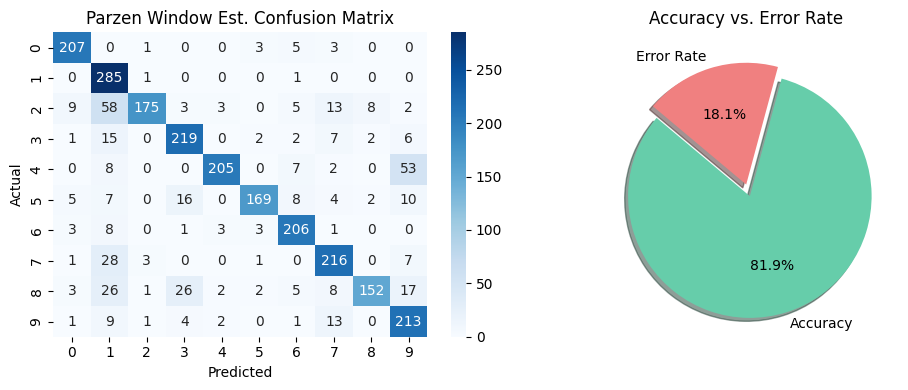

In [14]:
predicted_probabilities, predicted_labels = bayes_classifier(
    est_param=1, kernel=kernel_gaussian
)
accuracy = accuracy_score(target_labels=y_test_set, predicted_labels=predicted_labels)
cm_parzen = confusion_matrix(
    y_true=y_test_set, y_pred=predicted_labels, labels=range(0, 10)
)
visualize_accuracy(
    cm=cm_parzen, technique_title="Parzen Window Est.", accuracy=accuracy
)

### 4.1.2: 1 run with h = 1 and Rectangular kernel

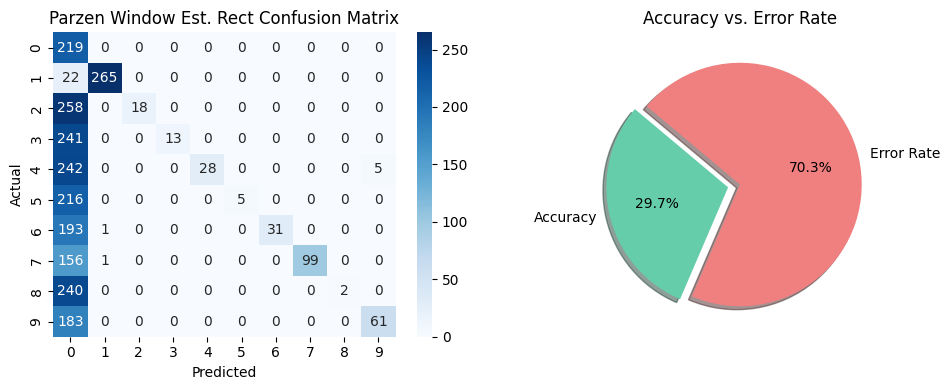

In [16]:
rect_predicted_probabilities, rect_predicted_labels = bayes_classifier(
    est_param=1, kernel=kernel_rect
)
rect_accuracy = accuracy_score(
    target_labels=y_test_set, predicted_labels=rect_predicted_labels
)
cm_parzen_rect = confusion_matrix(
    y_true=y_test_set, y_pred=rect_predicted_labels, labels=range(0, 10)
)
visualize_accuracy(
    cm=cm_parzen_rect, technique_title="Parzen Window Est. Rect", accuracy=rect_accuracy
)

### 4.1.3: Dynamic h recruiting 2 kernels

In [20]:
parzen_results_table = PrettyTable(
    ["h", "Gaussian Kernel Accuracy %", "Rectangular Kernel Accuracy %"]
)

for h in np.arange(1, 2.2, 0.1):
    g_predicted_probabilities, g_predicted_labels = bayes_classifier(
        est_param=h, kernel=kernel_gaussian
    )
    rect_predicted_probabilities, rect_predicted_labels = bayes_classifier(
        est_param=h, kernel=kernel_rect
    )

    g_kernel_accuracy = accuracy_score(
        target_labels=y_test_set, predicted_labels=g_predicted_labels
    )
    rect_kernel_accuracy = accuracy_score(
        target_labels=y_test_set, predicted_labels=rect_predicted_labels
    )

    parzen_results_table.add_row(
        [
            f"{h:.2f}",
            f"{g_kernel_accuracy * 100:.2f}%",
            f"{rect_kernel_accuracy * 100:.2f}%",
        ]
    )

print(parzen_results_table)

+------+----------------------------+-------------------------------+
|  h   | Gaussian Kernel Accuracy % | Rectangular Kernel Accuracy % |
+------+----------------------------+-------------------------------+
| 1.00 |           81.91%           |             29.65%            |
| 1.10 |           79.43%           |             37.90%            |
| 1.20 |           76.91%           |             49.34%            |
| 1.30 |           74.35%           |             60.38%            |
| 1.40 |           72.07%           |             72.11%            |
| 1.50 |           69.99%           |             79.83%            |
| 1.60 |           68.43%           |             82.51%            |
| 1.70 |           66.43%           |             81.23%            |
| 1.80 |           65.15%           |             75.99%            |
| 1.90 |           63.91%           |             69.35%            |
| 2.00 |           62.67%           |             11.48%            |
+------+------------

## 4.2 KNN

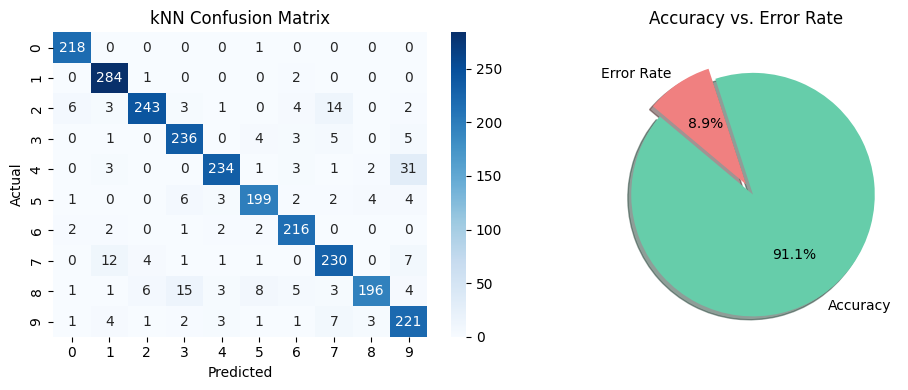

In [22]:
predicted_probabilities, predicted_labels = bayes_classifier(est_param=1)
accuracy = accuracy_score(target_labels=y_test_set, predicted_labels=predicted_labels)
cm_knn = confusion_matrix(
    y_true=y_test_set, y_pred=predicted_labels, labels=range(0, 10)
)
visualize_accuracy(cm=cm_knn, technique_title="kNN", accuracy=accuracy)

In [23]:
knn_accuracy_table = PrettyTable(["k", "kNN Accuracy %"])

for k in range(1, 4):
    predicted_probabilities, predicted_labels = bayes_classifier(est_param=k)

    knn_accuracy = accuracy_score(
        target_labels=y_test_set, predicted_labels=predicted_labels
    )

    knn_accuracy_table.add_row([k, f"{knn_accuracy * 100:.2f}%"])

print(knn_accuracy_table)

+---+----------------+
| k | kNN Accuracy % |
+---+----------------+
| 1 |     91.12%     |
| 2 |     90.80%     |
| 3 |     90.52%     |
+---+----------------+
